In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

from pythtb import W90, TBModel
import pythtb
import logging

pythtb.configure_logging(level="DEBUG")

<StreamHandler stderr (NOTSET)>

In [3]:
E_F = 7.5901 # eV

## PythTB `W90`

In [4]:
mode_0_dir = "base"
mode_1_dir = "mode_1"
# mode_2_dir = "133803bc889"

In [5]:
MBT = W90(mode_0_dir, r"MnBi2Te4")

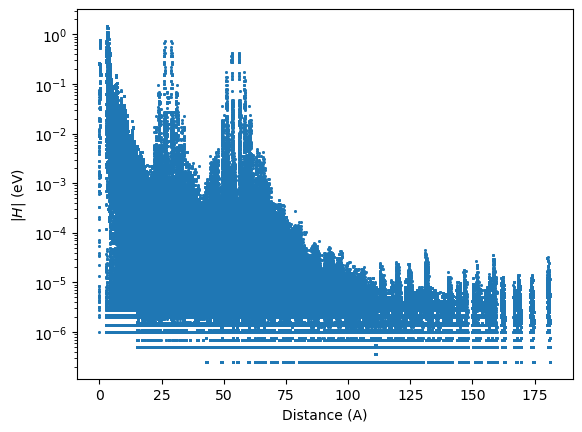

In [6]:
# plot hopping terms as a function of distance on a log scale
(dist, ham) = MBT.dist_hop()
fig, ax = plt.subplots()
ax.scatter(dist, np.abs(ham), s=1)
ax.set_xlabel("Distance (A)")
ax.set_ylabel(r"|$H$| (eV)")
ax.set_yscale('log')

In [7]:
# %lprun -f MBT.model -f TBModel._append_hops -f model._hoptable.extend MBT.model(zero_energy=E_F, min_hopping_norm=1e-4, max_distance=None, ignorable_imaginary_part=None)

# Wannier90 bands

In [8]:
k_frac_w90, w90_evals, k_dist_w90, k_nodes_w90, k_labels_w90 = MBT.bands_w90(return_k_dist=True, return_k_nodes=True)

In [9]:
w90_evals_shift = w90_evals - E_F

## PythTB bands

In [10]:
# get tb model in which some small terms are ignored
model = MBT.model(
    zero_energy=E_F, min_hopping_norm=1e-5,
    max_distance=None, ignorable_imaginary_part=None
    )

In [11]:
k_vec, k_dist, k_node_dist = model.k_path(k_nodes_w90, nk=400, report=False)

In [12]:
pythtb_evals = model.solve_ham(k_vec, use_tensorflow=True)

DEBUG pythtb.tbmodel: Initializing Hamiltonian...
DEBUG pythtb.tbmodel: Diagonalizing Hamiltonian...


## Quantum Espresso bands

In [13]:
k_frac_qe, qe_evals, k_dist_qe, k_cart_qe = MBT.bands_qe(return_kdist=True, return_k_cart=True)

# Bands comparison

In [14]:
outer_window = [-7, 20] # eV
inner_window = [0, 10] # eV

Text(0.5, 1.0, 'MnBi$_2$Te$_4$ Bands')

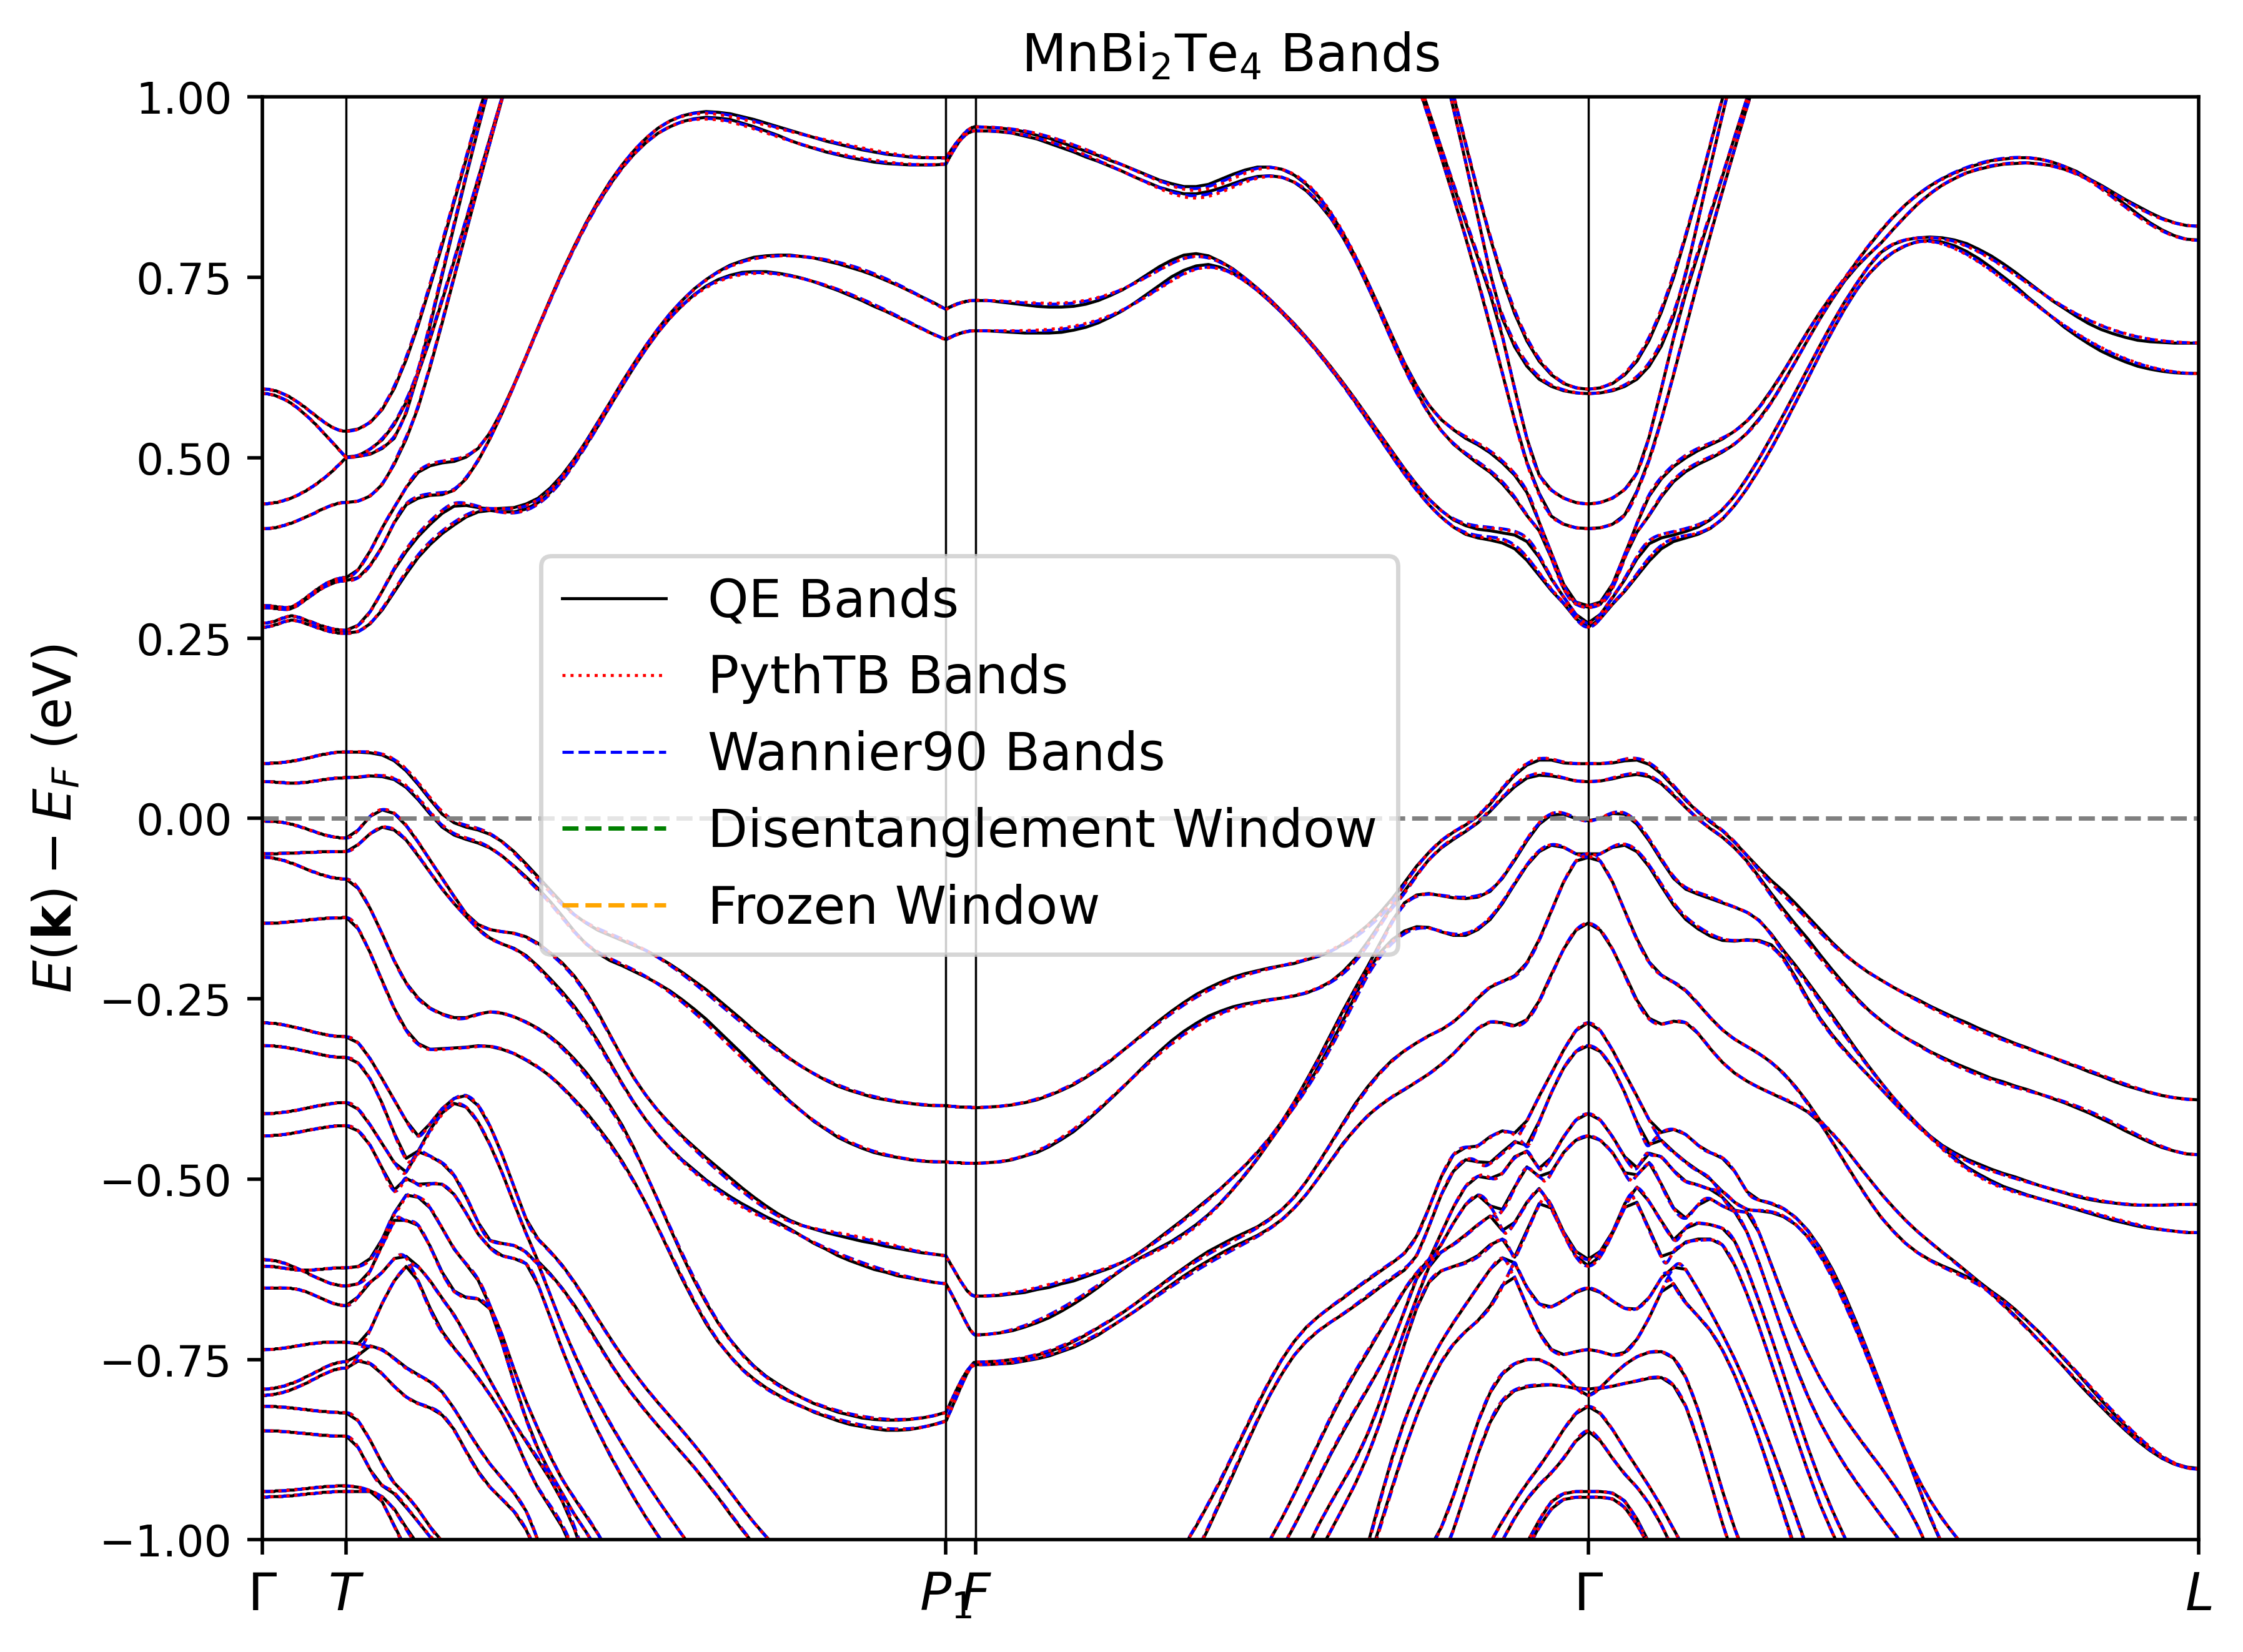

In [15]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=500)

for i in range(qe_evals.shape[1]):
    if i == 0:
        ax.plot(k_dist_qe, qe_evals[:, i] - E_F, c="k", ls="-", label='QE Bands', lw=0.7, zorder=0)
    else:
        ax.plot(k_dist_qe, qe_evals[:, i] - E_F, c="k", ls="-", lw=0.7, zorder=0)

for i in range(w90_evals.shape[1]):
    if i == 0:
        ax.plot(k_dist, pythtb_evals[:, i], c="r", ls=":", label='PythTB Bands', lw=0.7, zorder=2)
        ax.plot(k_dist_w90, w90_evals_shift[:, i], c="b", ls="--", label='Wannier90 Bands', lw=0.7, zorder=1)
    else:
        ax.plot(k_dist, pythtb_evals[:, i], c="r", ls=":", lw=0.7, zorder=2)
        ax.plot(k_dist_w90, w90_evals_shift[:, i], c="b", ls="--", lw=0.7, zorder=1)

ax.set_xticks(k_node_dist)
for n in range(len(k_node_dist)):
    ax.axvline(x=k_node_dist[n], linewidth=0.5, color="k", zorder=1)
ax.set_xticklabels(k_labels_w90, size=12)

ax.set_ylabel(r"$E(\mathbf{k}) - E_F$ (eV)", size=12)

ax.axhline(0, linestyle='--', color='gray', lw=1)
ax.axhline(outer_window[0]-E_F, linestyle='--', color='g', lw=1, label='Disentanglement Window')
ax.axhline(outer_window[1]-E_F, linestyle='--', color='g', lw=1)
ax.axhline(inner_window[0]-E_F, linestyle='--', color='orange', lw=1, label='Frozen Window')
ax.axhline(inner_window[1]-E_F, linestyle='--', color='orange', lw=1)

ax.set_xlim(k_dist[0], k_dist[-1])
ax.set_ylim(-1, 1)

ax.legend(bbox_to_anchor=(0.6, 0.7),fontsize=12)
ax.set_title(r"MnBi$_2$Te$_4$ Bands")